## Model development: prototype different models

Description: 

In section 1) Model tuning (hyperparameter selection) - decide on the number of topics (n_components) to use in the model. Run 5-fold cross validation for n_components in range (2-30). Use perplexity calculated on the test set as the evaluation criteria

In section 2) train full model with optimal number of topics determined from section 1.


NMF code was adapted from: [scikit_learn](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py) - Authors: Olivier Grisel, Lars Buitinck, Chyi-Kwei Yau - License: BSD 3 clause

In [28]:
import pandas as pd
import numpy as np
from scipy import sparse
import time
import pickle
import gradio as gr

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF

import matplotlib.pyplot as plt

c:\Users\Nick\.conda\envs\recsys_movie\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [5]:
# read in movie database
df = pd.read_csv("data_preprocessing_eda_out\\df_spaces_upload.csv", index_col=[0])

# read in scipy sparse matrix
X = sparse.load_npz("data_preprocessing_eda_out\\X.npz")

with open("data_preprocessing_eda_out\\word_key.txt", "rb") as f:
    word_key = pickle.load(f)

n_movies = len(df)
n_features = len(word_key)

1) Fit full model with predetermined n_components

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=12000 and n_features=10000...
done in 84.022s.


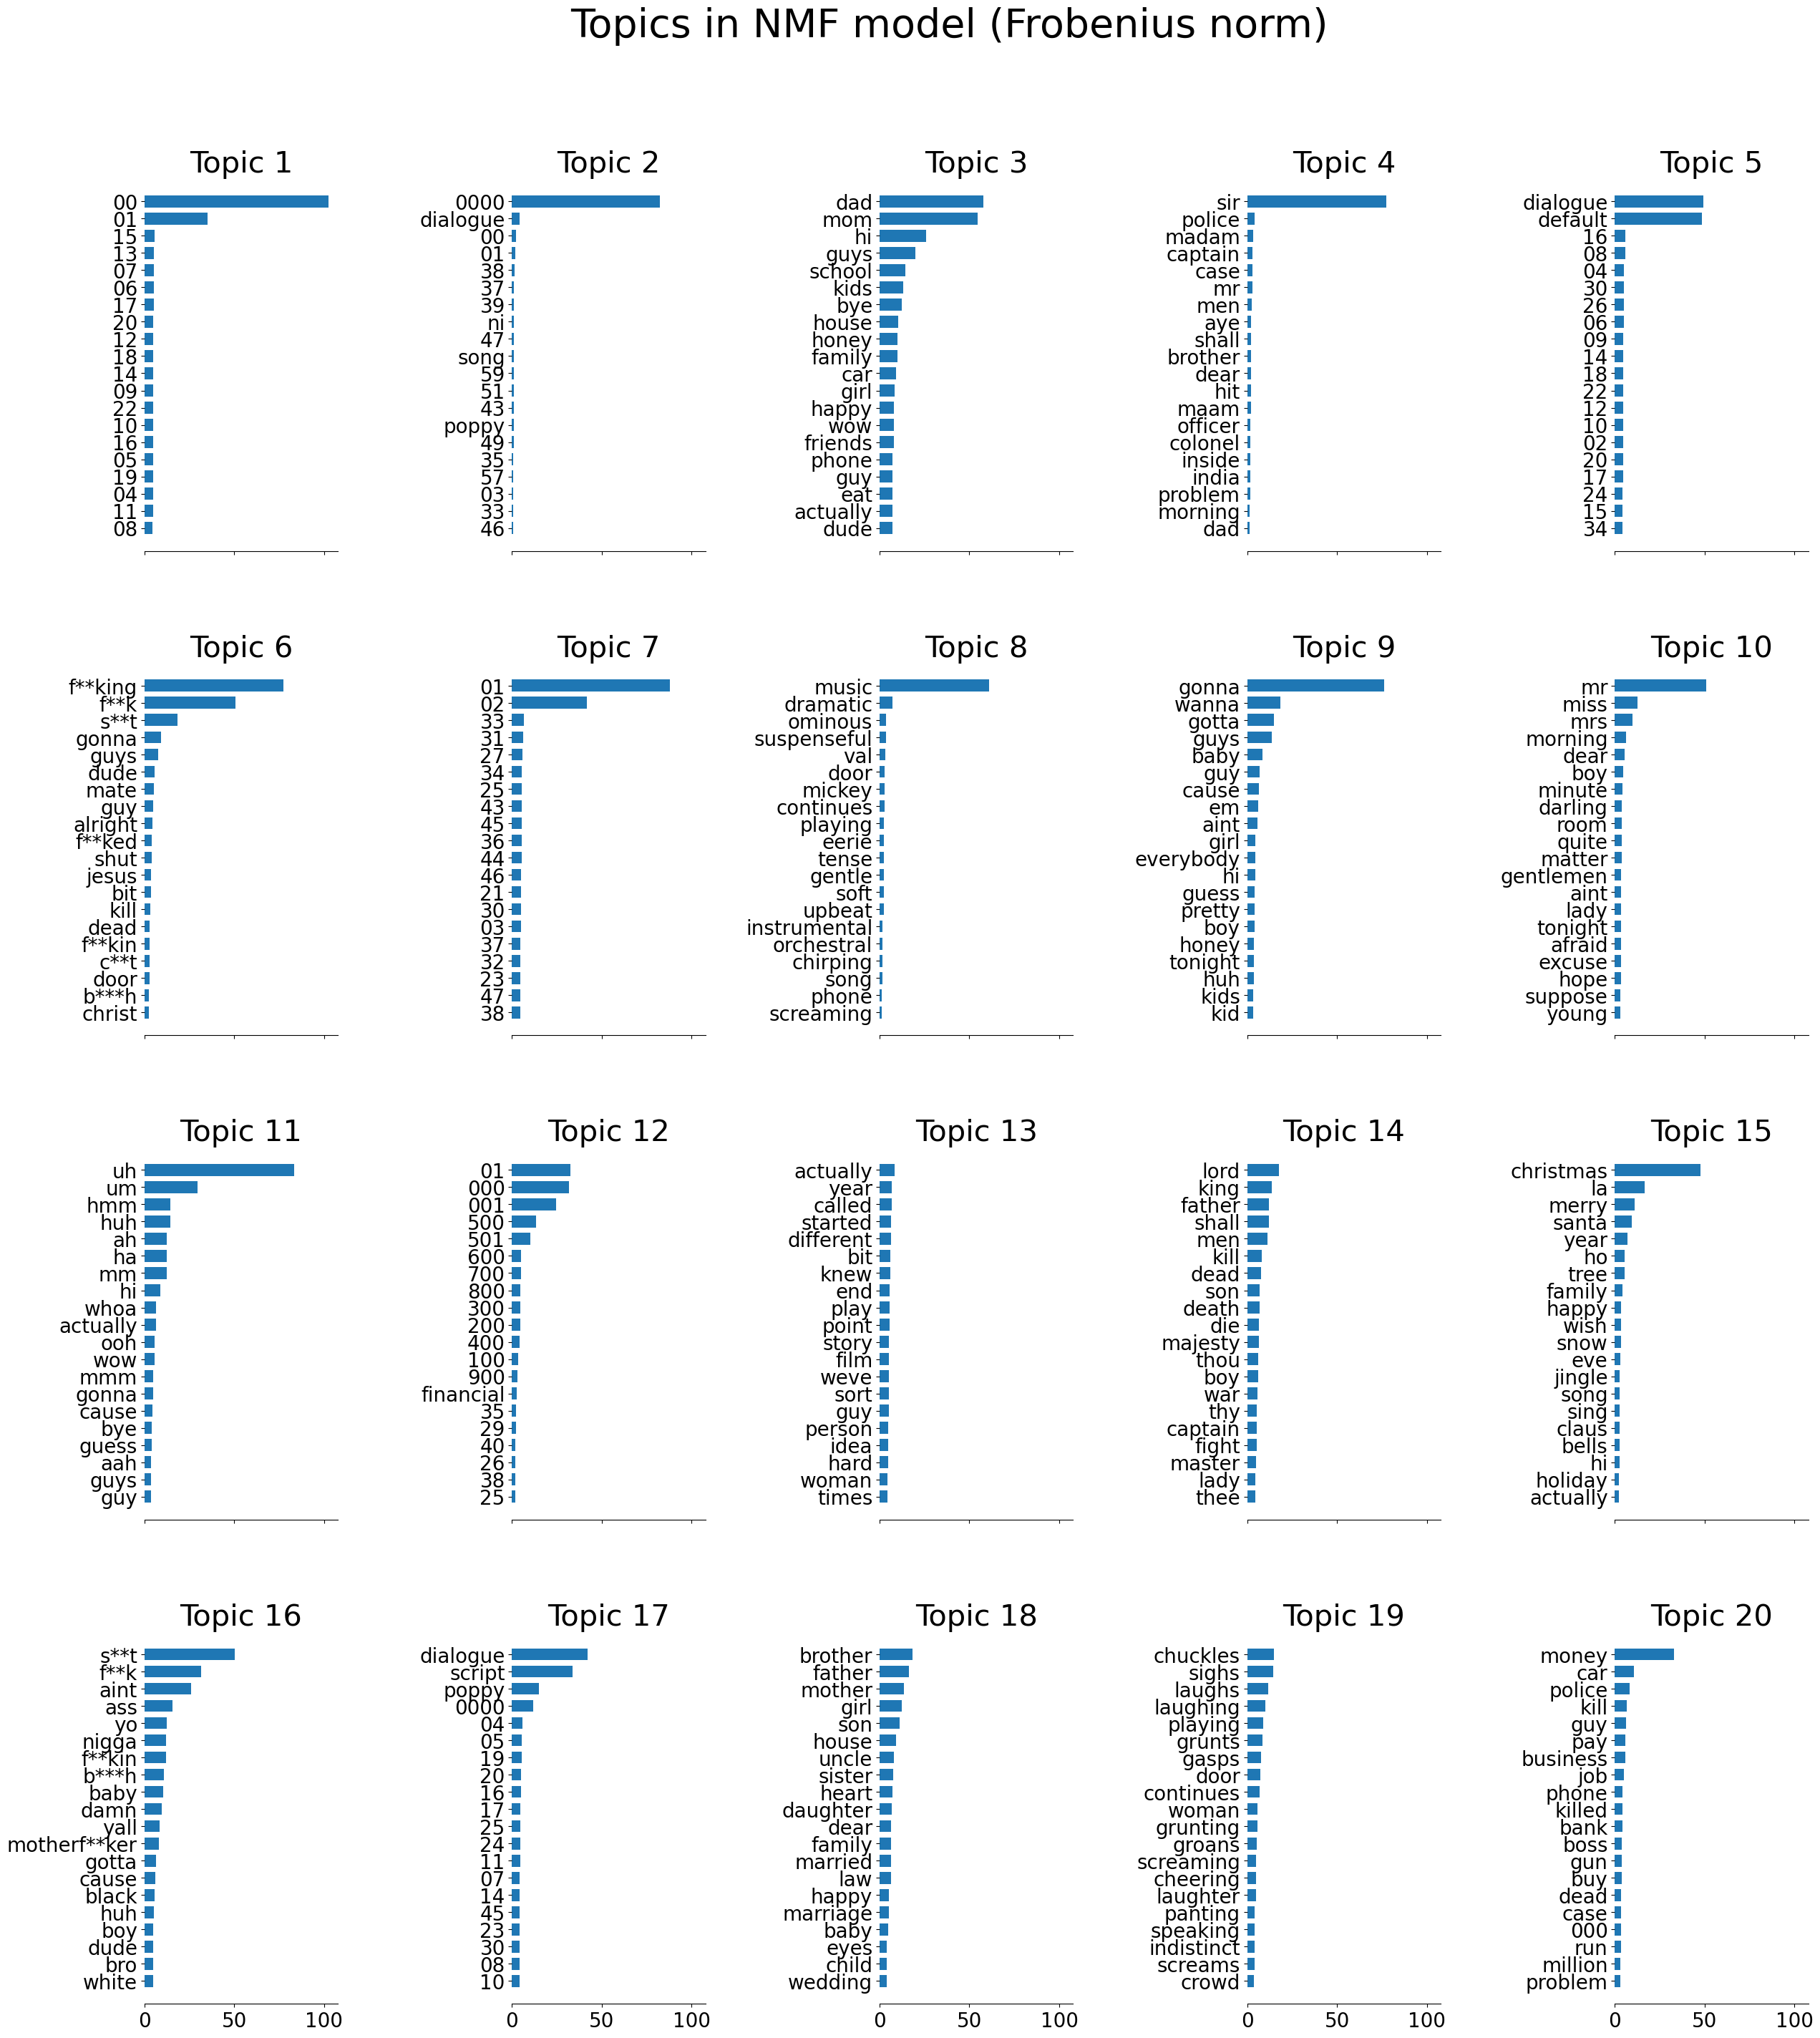

In [22]:
# fit model with optimal value for n_components

# model inputs
n_samples = 12000
n_components = 20
n_top_words = 20

# construct train/test split
X_train, X_test = train_test_split(X, train_size=n_samples, test_size=1000, random_state=22)

# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
t0 = time.time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init="nndsvda",
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
    max_iter=800,
    tol=1e-4
).fit(X_train)
print("done in %0.3fs." % (time.time() - t0))


plot_top_words(
    nmf, word_key, n_top_words, "Topics in NMF model (Frobenius norm)"
)

In [25]:
Xtran_nmf = nmf.transform(X)

In [27]:
with open('model_devel\\Xtran_nmf.txt', 'wb') as f:
    pickle.dump(Xtran_nmf,f)    
pickle.dump(nmf, open('model_devel\\model_nmf_2023_08_26.sav', 'wb'))

In [29]:
def movie_rec(movie_name, rating_min, is_adult, Xtran):
    # compute top 5 movie recommendations for the input movie and filters
    # inputs:
    #       movie_name: selected movie_name from radio
    #       rating_min: filter out all movies with ratings less than rating_min
    #       is_adult: if True then filter out adult titles
    # ouputs:
    #       df_in: dataframe with all the info on movie_name
    #       df_out: dataframe with all the info on top 5 recommended movies

    if not movie_name:
        raise gr.Error("Please select a movie before clicking Recommend")

    jmovie = df[df["movie_title"] == movie_name].index[0]
    sim_in = Xtran[jmovie, :].reshape(1, Xtran.shape[1])

    if "NULL" in df["imdb_link"].iloc[jmovie]:
        # input movie has no matching IMDb title
        link_in = ["N/A"]
        genre_in = ["N/A"]
        rating_in = ["N/A"]
    else:
        # link_in = construct_markdown_link([df["imdb_link"].iloc[jmovie]], [movie_name])
        genre_in = [df["genre"].iloc[jmovie]]
        rating_in = [df["average_rating"].iloc[jmovie]]

    # construct input dataframe
    df_in = pd.DataFrame(
        {
            "Title": [movie_name],
            "Year": [df["movie_year"].iloc[jmovie]],
            "IMDb Rating": rating_in,
            "Genres": genre_in,
            # "IMDb Link": link_in,
        }
    )

    # compute similarity between movie_name and all other movies in database
    sim_movie = cosine_similarity(sim_in, Xtran).reshape((len(df),))

    # sort dataframe by movie similarity in descending order
    arg_sim_movie_ordered = np.flip(np.argsort(sim_movie))
    df_sort = df.iloc[arg_sim_movie_ordered[1:]]

    # fiter by rating_min and is_adult
    df_sort = df_sort[df_sort["average_rating"] >= float(rating_min)]
    if is_adult:
        df_sort = df_sort[df_sort["is_adult"] == 0]

    # raise error if less than 5 movies are left after filtering
    if len(df_sort) < 5:
        raise gr.Error(
            "Not enough movies met the filter criteria. Try reducing the minimum rating."
        )

    # construct output dataframe
    movie_title = df_sort["movie_title"].iloc[0:5].tolist()
    movie_year = df_sort["movie_year"].iloc[0:5].tolist()
    rating = df_sort["average_rating"].iloc[0:5].tolist()
    genre = df_sort["genre"].iloc[0:5].tolist()
    # link = construct_markdown_link(df_sort["imdb_link"].iloc[0:5].tolist(), movie_title)

    df_out = pd.DataFrame(
        {
            "Title": movie_title,
            "Year": movie_year,
            "IMDb Rating": rating,
            "Genres": genre,
            # "IMDb Link": link,
        }
    )

    return df_in, df_out

In [31]:
# define some test cases - will be used as examples in app
plt.rcParams.update({"font.size": 14})
tested_examples = [
    ["Barbie", "5", True],
    ["Green Book", "6.9", True],
    ["Finding Nemo", "6", True],
    ["How to Train Your Dragon", "6.7", True],
    ["Remember the Titans", "5", True],
    ["Avengers: Endgame", "7.4", True],
]


for ex in tested_examples:
    df_in, df_out = movie_rec(ex[0], ex[1], ex[2], Xtran_nmf)
    # df_in2, df_out2 = movie_rec(ex[0], ex[1], ex[2], Xtran20)
    print(df_in.to_markdown() + '\n')
    print(df_out.to_markdown() + '\n')
    # print(df_out2.to_markdown() + '\n')
    print('----------------------------------------------------------------------------------------\n')

|    | Title   |   Year |   IMDb Rating | Genres                   |
|---:|:--------|-------:|--------------:|:-------------------------|
|  0 | Barbie  |   2023 |           nan | Adventure,Comedy,Fantasy |

|    | Title                           |   Year |   IMDb Rating | Genres               |
|---:|:--------------------------------|-------:|--------------:|:---------------------|
|  0 | Kizoku Kourin: Prince of Legend |   2020 |           6.4 | Drama                |
|  1 | Un traductor                    |   2018 |           7   | Drama                |
|  2 | Kamome shokudo                  |   2006 |           7.2 | Comedy,Drama         |
|  3 | Golden Land                     |   2022 |           6.9 | Documentary          |
|  4 | Tel Aviv on Fire                |   2018 |           6.7 | Comedy,Drama,Romance |

----------------------------------------------------------------------------------------

|    | Title      |   Year |   IMDb Rating | Genres                 |
|---:|:-